In [61]:
"""
Moving averages ucinaja mi zyski... One maja sens tylko pozornie. Jak patrze na wykres widze ze zwykle 
wtedy byly wzrosty. Ale jak wezmiesz pod uwage:
- wejscie na koncu dnia (czesto wzrost juz byl duzy w tym momencie)
- wyjscie po tym gdy srednia opada (dopiero x dni pozniej)
Dlatego zreszta ludzie wymyslali 2 srednie (krotkie i dlugie)

Jezeli chodzi o wykrycie trendu srednia nie jest duzo lepsza od Janusza patrzacego na wykres...

Musze podejsc do tego bardziej usystematyzowanie... A nie probowac jakies zasady z dupy

- Zakladajac cene X i koszt transakcji Y, jaki wzrost ceny jest potrzebny do zarobienia czegokolwiek?

- Jak czesto w zalozonym okresie cena wzrosla w poprzednich lb dniach o wymagany % ?
    - Czy sa okresy gdy czestotliwosc jest wieksza?
        -> W teori przy trendzie wzrostowym tak powinno byc
    - Jak wyglada funcka f(lb) -> break_even
    - Czy widac podobienstwa na innych symbolach?
- Jakie bylby expected return dla zalozonego okresu?
    expected_return = p(win)*avg(win) + p(loss)*avg(loss)

Pomysl-1:
- Zakladajac istnie wydluzonych okresow w ktorych cena rosnie (upward trend)
- W takim okresie przewidywany wzrost ceny bedzie pozytywny, tj. srednio bez specjalnych 
    zdolnosci jezeli zainwestujesz przez X dni to zyskasz
- Jezeli jestem w stanie mniej wiecej okreslic czy dana spolka jest w takim okresie moge w nia inwestowac na X dni
- Problematyczne kwestie:
    -> Jak zdefiniowac taki okres na podstawie danych historycznych?
    -> Ile jeszcze dana spoka pozostanie w takim stanie?
    -> Czy to nie jest tak trudne zadanie jak przewidzenie ruchu ceny? Czy nie zamieniam jedego niemozliwego
        problemu na drugi?
- [?] Jak szybko w danym okresie (po ile transakcjach) returns zebiegaja sie z oczekiwanymi?
    Okres powinien trwac na tyle dlugo ze po jego wykryciu jestem w stanie zrobic tyle transakcjii.
    W zaleznosci od ilosc transakcji bede wtedy tez w stanie okreslic czy gra jest warta swieczki...
    



Asymetrical approach (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2903855):
- This artical confirms that simple Moving Average approach is often used to identified up/down trends
- There is information assymetry in up/down trends. Up trends tends to have less abrupt begining. Down trends
tend to start more rapidly (short price fall at the end of up-trend / beg of down-trendd)
- The results show that a more responsive way (i.e. using a shorter MA length) to locate the ending time points of uptrends always
helps to achieve a better average return.
- Described startegy is long/short. It would need modification for long-only
- In general, use one pair (long and short SMA) to identify LONG ENTRY, and the other pair (shorter) to define LONG EXIT




""";

In [62]:
"""
Co pomogloby mi w decyzji oprocz ceny?

- Competitors and|or index performance 
- Volume and price (bull vs. bear on given day)
- Rate of changes
- Recent maxima | minima and time passed since then


behaviours:
- Following the crowd (even if it make not make sense)
- Fear for loss is bigger than possibile profit
- Gambler’s fallacy
- contrarian forex trader would typically take a long position in a currency pair 
when there is an overwhelming degree of pessimism that has pushed the price of the asset 
down to an extreme level that is below what it is intrinsically worth.

""";

In [63]:
"""
Processing flow:
- Prepare data
- Get random periods from data (with all necessery columns)
- Calculate competitors metrics
- Calcualte sentiment metrics
- Show all resuls
""";

In [64]:
"""
Volume is counted as the total number of shares that are actually traded (bought and sold) during the 
trading day or specified set period of time.


100 transakcji
cena spadla o 5 zl
co to znaczy?


Sentiment, usually -> is market/stock/etc. 
    bullish (more people think it will go up)
    bearish (more people think it will go down)

In theory, if more and more people will think it will go up, they will hold their positions. Also more people
would like to buy it (driving price up)

no pos/neg days weighted by volume? volotality could also be helpful...

Anyway, don't fall into the trap of "perfect" indicator that with high certanity predicts... Smartest people and
funds can't do it.

What you are looking at is to trade the way that without certenity or "holy grail" you can have higher profits
that passive buy&hold. 



How to test (statistiically) if used approach (hypothesis) has any sense?
- Draw random symbol/period - test performance over many traials
- Compare the above with benchmark performance. Performance achieved with method on randomly generated data. 


TODOs:
OK - Clean script (names, cells, etc.). It should be easy to restart kernel without worry
OK - Create POC function that will allow to:
    -> run single cell
    -> see data and make unbiased human decision for the investment
    -> write assumptions and observation
    -> compare it with 2nd period. Was I right? what could be done better
- Come up with good set of rules that can be codified
- Codify assumptions and create function to test approach on many trials
"""
;

''

In [65]:
########################
### AFTER CLEAN UP
########################

In [66]:
# built in
import random
import sys
sys.path.insert(0, '/Users/slaw/osobiste/trading')

# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
# logging.debug("test")

# 3rd party
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates

import numpy as np
import pandas as pd

# custom
from lse_data import LSEData
# from backtester import Backtester
# from signal_generator import SignalGenerator
# from strategies import helpers
# from ftse_symbols import ftse_100
import ftse_symbols

# import position_size
# import results
# import helpers
# import rules

In [67]:
%matplotlib notebook
register_matplotlib_converters()

In [68]:
def get_base_data(print_sample=True):
    """
    Gets FTSE100 data from disk and loads it as {symbol: df}
    """
    lse_data = LSEData(pricing_data_path='/Users/slaw/osobiste/trading/pricing_data')
    universe = lse_data.load(
        symbols=lse_data.indicies_stocks['FTSE100']
    )
    if print_sample:
        print(f'No. of stocks in universe: {len(universe.keys())}')
        print('Sample data:')
        print(universe['AAL'].tail(10))
    return universe

In [69]:
def needed_price_rise(entry_price=None, trx_cost=6, trx_type='long', profit=0):
    """
    Returns how much price need to rise (long) in order to achieve given profit
    """
    fees = 2*trx_cost
    if trx_type == 'long':
        exit_price = profit + fees + entry_price
        perc_increase = (exit_price-entry_price)/entry_price
        return perc_increase

print(needed_price_rise(entry_price=100, profit=0))

0.12


In [70]:
def winrate_expected_return(arr, lb, profit=0):
    """
    Given array of prices, lookback period and desired profit - calculate winrate and expected returns.
    
    Metrics are based on assumption that one makes trade every day, holds it for lookback period. It can be
    interpreted as winrate/expected return of random trade (that lasted "lb" days) over given period (arr).
    """
    cnt_all = 0
    cnt_pos = 0
    sum_win = 0
    sum_loss = 0
    for idx, exit in enumerate(arr):
        if idx < lb-1:
            continue
        entry = arr[idx-(lb-1)]
        diff = (exit - entry)
        perc_diff = diff/entry

        req_change = needed_price_rise(
            entry_price=entry,
            profit=profit # 0 = break even
        )

        if perc_diff >= req_change:
            cnt_pos += 1
            sum_win += diff
        else:
            sum_loss += abs(diff)

        cnt_all += 1

    perc_win = round((cnt_pos/cnt_all)*100,0)
    
    if cnt_pos == 0:
        expexted_ret = -sum_loss/(cnt_all-cnt_pos)
    elif sum_loss == 0:
        expexted_ret = sum_win/cnt_pos
    else:
        expexted_ret = (perc_win/100)*(sum_win/cnt_pos) - ((100-perc_win)/100)*(sum_loss/(cnt_all-cnt_pos))
    expexted_ret = round(expexted_ret, 1)
    
    return perc_win, expexted_ret

In [71]:
def print_symbol_sectors_frequency():
    sectors= {}
    for el in ftse_symbols.ftse_100:
        sector = el['sector']
        if sector in sectors:
            sectors[sector] += 1
        else:
            sectors[sector] = 1
    for k, v in sorted(list(sectors.items()), key=lambda x: x[1], reverse=True):
        print(f'{k}: {v}')

print_symbol_sectors_frequency()

Support Services: 8
Insurance: 7
Media: 6
Financial Services: 5
Banks: 5
Household Goods & Home Construction: 5
Gas, Water & Multi-utilities: 5
Mining: 4
Metals & Mining: 4
Travel & Leisure: 4
Food & Drug Retailers: 4
General Industrials: 4
Pharmaceuticals & Biotechnology: 3
Software & Computer Services: 3
Real Estate Investment Trusts: 3
Retailers: 2
Aerospace & Defence: 2
Oil & Gas Producers: 2
Tobacco: 2
Telecommunications: 2
Personal Goods: 2
Beverages: 2
Chemicals: 2
General Retailers: 2
Food Producers: 1
Construction & Materials: 1
Travel and Leisure: 1
Electronic & Electrical Equipment: 1
Consumer services: 1
Investment Services: 1
Automobiles & Parts: 1
Forestry & Paper: 1
Equity Investment Instruments: 1
Health Care Equipment & Services: 1


In [72]:
def prepare_data(universe, ma=25, ma_label='close'):
    """
    Given raw data (e.g. output from `get_base_data`) run some computations (e.g. moving average) that can/will
    be used later on.
    Idea is to run things that requires whole time series. Things that would be harder to compute when one
    have just randomly selected chunk of time-series.
    """
    data = {}
    for symbol, org_df in universe.items():
        df = pd.DataFrame()
        df[f'ma{ma}'] = org_df[ma_label].rolling(ma).mean()
        prepared_symbol = pd.concat(
            [org_df, df],
            axis=1,
        )
        prepared_symbol = prepared_symbol[ma:]
        data[symbol] = prepared_symbol
    return data

In [73]:
def get_random_symbol_period(lb=None, lf=None, universe=None):
    """
    Given universe of data, randomly select symbol and cut two time serieis from it.
    First one will have lenght of lookback (`lb`) and the second one will start chronologically
    right after 1st one, but will last for lookforward (`lf`) days.
    
    Think about it as two consequitive time periods for random symbol and random date.  
    """
    sym = random.choice(list(universe.keys()))
    data = universe[sym]
    
    # dates to choose from
    dates = data.index.tolist()
    idx = random.randint(lb+1, len(dates)-(lf-1))
    
    # define periods
    first_period = data[idx-lb : idx]
    second_period = data[idx : idx+lf]
    
    return sym, first_period, second_period

In [74]:
def index_stocks_for_period(universe=None, period=None, label='close'):
    """
    Given `universe` and `label` calculate basic statistics for all symbols in the unvierse in given `period`.
    Metrics are:
        - list of daily returns
        - avg. daily return
        - total % change
        - volatility (as normalized standard deviation)
    
    """
    lst_period = period.index.tolist()
    start = lst_period[0]
    end = lst_period[-1]
    res = {}
    for sym, df in universe.items():
        data = df[start:end][label]
        if len(data) == 0:
            continue
        res[sym] = {}
        res[sym][label] = data.tolist()
        res[sym]['daily_ret'] = data.pct_change(1).tolist()[1:]
        res[sym]['avg_daily_ret'] = np.mean(res[sym]['daily_ret'])
        res[sym]['total_perc_change'] = (res[sym][label][-1] - res[sym][label][0]) / res[sym][label][0]
        res[sym]['volatility'] = np.std(res[sym][label]) / np.mean(res[sym][label])
    return res

In [75]:
def _sector_index_metrics(symbol, symbols_lst, index_stocks_data, label):
    """
    Helper func for compare_sector_index.
    ranks -> bigger is better
    len(data) -> contains all symbols (symbols_lst+symbol)
    """
    if len(symbols_lst) == 0:
        return {}
    data = []
    for s in (symbols_lst + [symbol]):
        if s not in index_stocks_data:
            continue
        data.append(
            (s, (
                index_stocks_data[s]['avg_daily_ret'],
                index_stocks_data[s]['total_perc_change'],
                index_stocks_data[s]['volatility'])
            )
        )
        
    ordered_ret = sorted([(s, m[0]) for s, m in data], key = lambda x: x[1])
    ordered_total_change = sorted([(s, m[1]) for s, m in data], key = lambda x: x[1])
    ordered_vol = sorted([(s, m[2]) for s, m in data], key = lambda x: x[1])
    return {
        f'{label}_cnt': len(data),
        f'{label}_return_rank': [s for s, _ in ordered_ret].index(symbol) + 1,
        f'{label}_volatility_rank': [s for s, _ in ordered_vol].index(symbol) + 1,
        f'{label}_total_change_rank': [s for s, _ in ordered_total_change].index(symbol) + 1,
        f'{label}_avg_daily_ret': np.mean([m[0] for s, m in data if s != symbol])
    }


def compare_sector_index(index_symbols=None, symbol=None, index_stocks_data=None):
    """
    For given symbol calculate index and sector metrics. It is done be comparing
    symbol data with statistics from `index_symbols` (index_stocks_for_period function output)
    """
    symbol_sector = [el['sector'] for el in index_symbols if el['symbol']==symbol][0]
    symbol_competitors = {
        'sector': [],
        'index': [],
    }
    # Get sectors frequency and competitors
    sector_competitor_cnt = 0
    for el in index_symbols:
        if el['symbol'] == symbol:
            continue
        sector = el['sector']
        if sector == symbol_sector:
            sector_competitor_cnt += 1
            symbol_competitors['sector'].append(el['symbol'])
        if el['symbol'] in index_stocks_data:
            symbol_competitors['index'].append(el['symbol'])
    # Index metrics
    index_metrics = _sector_index_metrics(
        symbol, symbol_competitors['index'], index_stocks_data, 'index'
    )
    # Sector (competitors) metrics
    if sector_competitor_cnt < 3:
        # not enoough competitors in sector. overwrite to []
        symbol_competitors['sector'] = []
    sector_metrics = _sector_index_metrics(
        symbol, symbol_competitors['sector'], index_stocks_data, 'sector'
    )
    # all metrics
    metrics = {}
    metrics['symbol_avg_daily_ret'] = index_stocks_data[symbol]['avg_daily_ret']
    metrics.update(index_metrics)
    metrics.update(sector_metrics)
    
    return metrics

In [155]:
def prep_df_to_ohlc(df):
    ohlc = pd.DataFrame()
    ohlc['date'] = pd.to_datetime(df.index)
    ohlc['date'] = ohlc['date'].apply(mpl_dates.date2num)
    for price in ['open', 'high', 'low', 'close']:
        ohlc[price] = df[price].values
    return ohlc

In [156]:
def show_periods_and_metrics(
    first_period=None, second_period=None, ma_label=None, max_random_hold=None, metrics=None
):
    """
    Input: periods (first and second) as well as soma additional things (all what is currently needed.
        things liike moving average lablel, index/sector metrics, more in future)
    Output:
        Visual representation of 1st period and all metrics, followed by 2nd period.
        
    Think about, given 1st period and all metrics, what would be my decision? And then, looking at 2nd period,
    would my decision be a good one?
    """
    fig, ax = plt.subplots(4, 1, figsize=(7,10))
    
    # Validity checks
    assert(len(first_period) >= max_random_hold)
    
    # Draw first period
    ohlc = prep_df_to_ohlc(first_period)
    candlestick_ohlc(ax[0], ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
    date_format = mpl_dates.DateFormatter('%d')
    ax[0].xaxis.set_major_formatter(date_format)
    # ax[0].tick_params(labelrotation=45)
    ax[0].set_title('First period', loc='center')
    
    # Draw close linr and moving average
    ys1 = first_period['close'].tolist()
    ma1 = first_period[ma_label].tolist()
    ax[0].plot(ohlc['date'], ma1)
    ax[0].plot(ohlc['date'], ys1)
    
    # Expected Returns ($) by holding period with random entry
    lb_range = list(range(2, max_random_hold))
    ers = [
        winrate_expected_return(ys1, lb)[1] 
        for lb in lb_range
    ]   
    ax[1].plot(lb_range, ers)
    ax[1].set_title('Expected Returns ($) by holding period with random entry', loc='center')
    
    # Draw table with metrics
    metrics_tbl = ax[2].table(
        cellText=[[k, round(metrics[k], 6)] for k in metrics.keys()],
        colLabels=['Metric', 'Value'], 
        loc='center', 
        cellLoc='center',
    )
    for (row, col), cell in metrics_tbl.get_celld().items():
        if (row == 0) or (col == -1):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    ax[2].axis("off")
    
    # Draw 2nd period (candles + close line)    
    ohlc_2nd = prep_df_to_ohlc(second_period)
    candlestick_ohlc(ax[3], ohlc_2nd.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
    ax[3].plot(ohlc_2nd['date'], second_period['close'].tolist())
    date_format = mpl_dates.DateFormatter('%d')
    ax[3].xaxis.set_major_formatter(date_format)
    ax[3].set_title('Second period', loc='center')
       
    plt.tight_layout()


In [160]:
def adhoc_random_trade_decision(universe=None, lb=25, lf=25, max_random_hold=14):
    rdn_sym, first_period, second_period = get_random_symbol_period(
        lb=lb,
        lf=lf,
        universe=universe
    )
    index_stocks_data = index_stocks_for_period(
        universe=new_universe,
        period=first_period,
    )
    metrics = compare_sector_index(
        index_symbols=ftse_symbols.ftse_100,
        symbol=rdn_sym,
        index_stocks_data=index_stocks_data,
    )
    show_periods_and_metrics(
        first_period=first_period,
        second_period=second_period,
        ma_label='ma25',
        max_random_hold=max_random_hold,
        metrics=metrics
    )

In [137]:
# basic set-up
universe = get_base_data()
new_universe = prepare_data(universe)

No. of stocks in universe: 98
Sample data:
              open    high     low   close     volume
date                                                 
2021-03-01  2825.0  2907.5  2819.0  2898.0  2760246.0
2021-03-02  2853.5  2967.0  2835.5  2957.5  4394822.0
2021-03-03  2996.5  3004.5  2895.5  2985.0  3340137.0
2021-03-04  2917.5  2933.0  2861.5  2887.0  3757954.0
2021-03-05  2852.5  2991.5  2835.0  2913.5  3379129.0
2021-03-08  2954.5  3020.0  2908.0  3018.5  2705013.0
2021-03-09  2958.0  2992.5  2836.5  2885.5  4199110.0
2021-03-10  2874.5  2912.0  2815.5  2857.0  2986262.0
2021-03-11  2923.0  2989.9  2908.5  2989.5  3953463.0
2021-03-12  2970.0  3030.5  2962.5  3028.4   126362.0


<IPython.core.display.Javascript object>


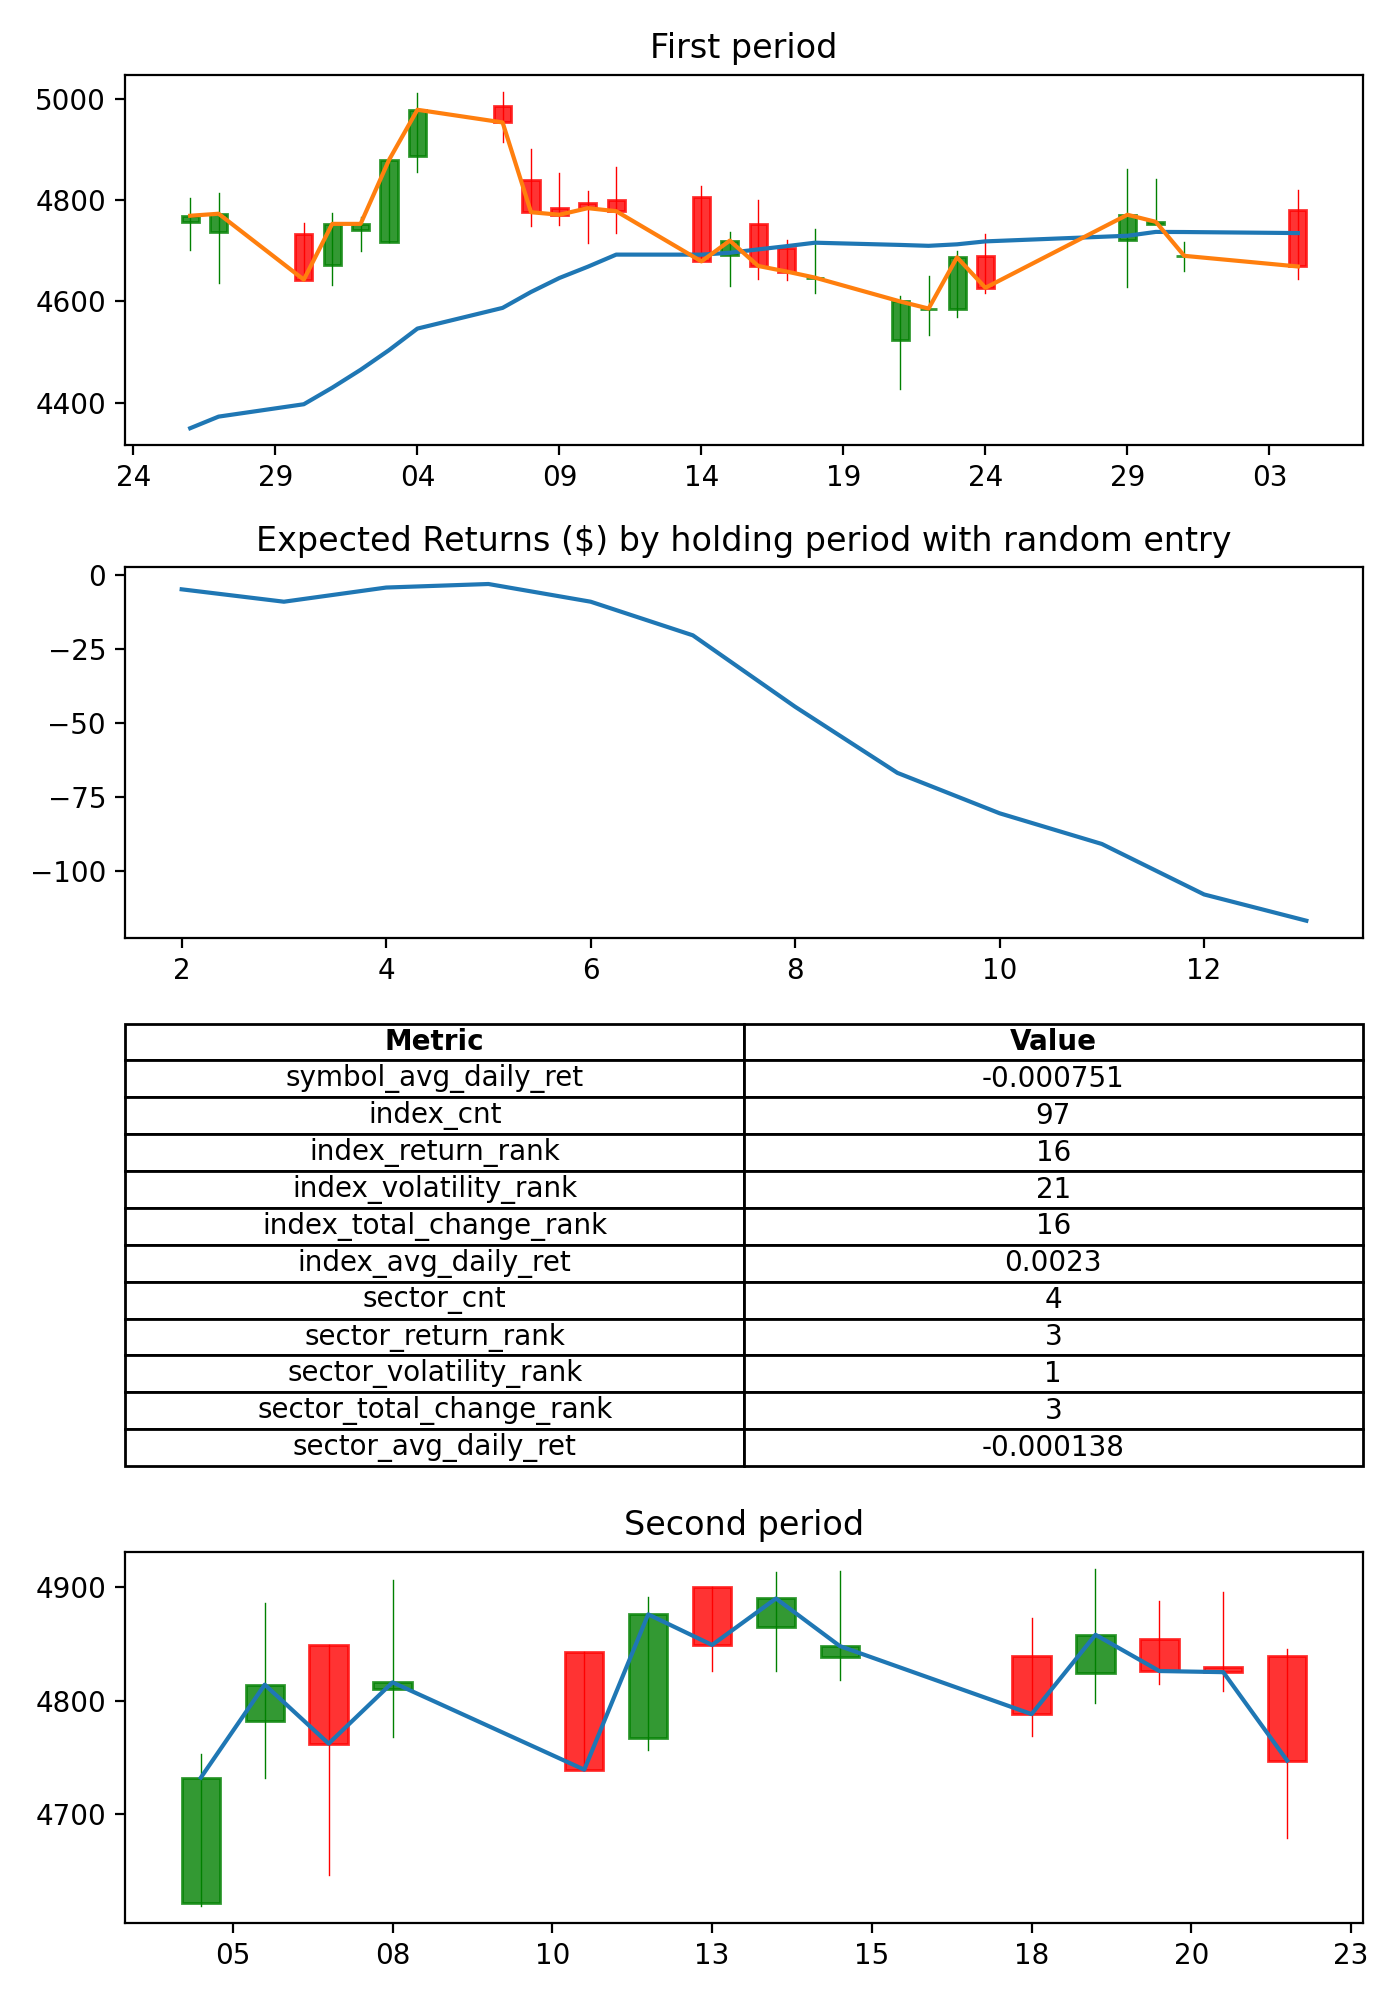

In [173]:
adhoc_random_trade_decision(
    universe=new_universe,
    lf=14,
)

In [23]:
"""
If you want to look at short term gain (matter of days) you cannot ignore intraday swings.
High|low price is must know for you. E.g. if you set-up stop loss, you can easily get wiped out by
quick move down. On the other hand, quick rally-up can satisfy you as well.

While enternig a trade you need to define both exit levels (SL exit, good exit). Those levels can be adjusted 
during the trade in some scenarios. E.g.:
    - For example, let's say that trade went your way and you hit good exit price. You can keep holding and see if 
    more gains can be sqeezd by modifyinig SL to good exit price. Then modify holding period or set new price level.
    - Scaling SL: one strategy is to adjust a SL as soon as price goes in right direction the way that you break
    even in case in turn to be wrong. Seems like good idea but may be hard to backtest with daily data... 
    
In general, you need yo be more dynamic while entering the trade. Having hard constraints, like hold X day, enter
or exit on x%, always enter/exit near the end of day (close price) etc. is too crude and naive.

At the end, what will matter is to have enough opportunities and resonable expected returns in the long run.
You will be able to scale over time with this.


Input parameters:
- entry decision
- initial SL level
- initial exit level
- iniitial holding period






"""


"""
Rzeczy na ktora patrze jako czlowiek:
1. Ile mozna bylo zarobic w ostatnim okresie trzymajc X dni?

Zalozenie: Podobnie jak w pasywnym inwestowaniu, patrze ile mozna bylo zarobic historycznie. Jezeli performance
jest dobry, zakladam ze mozliwe jest ze przez najblizszy okres wciaiz bedzie ok.

Nibespieczenstwa:
- Reversal (bylo dobrze alo to byla koncowka trendu)
- Missed opportunity (ostatni okres byl zly ale teraz wsakuje na dobre tory)

Teoretycznie sentiment data mogloby pomoc (np. dobry okres wg. ceny ale sentyment zly -> nie wchodz)

~Zasady:
+ Jezeli ~5-10dni mozna bylo zarobic to dobry znak
- Jezeli w ostatnim okresie moglem stracic - zly znak

2. Jak sobie radzi symbol w porownaniu z innymi w indeksie/sektorze?

Zalozenie: Chce inwestowac w lepszych. Zakladajac ze ten kto lepiej sobie radzi - bedzie tak kontynuowal

Niebezpieczenstwa:
Tak samo jak w 1. Bardziej generalnie, czy moje zalozenia sa ok dla relatywnie krotkiego okresu wachania ceny?

3. Jak dlugo cena jest ponad srednia i jaki jest trend?

E.g. cena idzie horyzontalnie ale jest caly czas nad MA ktore powoli dobija od dolu.
To by wsakzywalo na to ze pooprzednio byl wzrostowy ale teraz cos sie zablokowalo
""";

In [80]:
"""
Good entry
1111111

Good no-entry
11111111111111

Neutral entyr
1

Missed entry
111111111

Bad entry
111111



Notes:
- Missed entry jest wtedy gdy do strata w okresie najdluzszego mozliwego holding period
- Czy powinienem brac pod uwage dlugie przedluzanie okresu w ktorym trzymam?



""";